In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from keras.datasets import mnist
import numpy as np
from torch.utils.data import TensorDataset, DataLoader

## Loading the data
I load the MNIST dataset and normalize the pixel values to be between -1 and 1 because I am going to use Tanh as an activation function. Then I split the dataset to train and test sets.

In [12]:
# transform = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize((0.5,), (0.5,))
# ])
# mnist_train = datasets.MNIST(root = './data', train = True, download = True, transform = transform)
# train_loader = torch.utils.data.DataLoader(mnist_train, batch_size = 100, shuffle = True)
# Load dataset using Keras
(trainX, _), (_, _) = mnist.load_data()

# Normalize from [0, 255] → [-1, 1] to match Tanh() output
trainX = (trainX.astype(np.float32) - 127.5) / 127.5

# Flatten images to 784-dim vectors
trainX = trainX.reshape(-1, 28*28)

# Convert to PyTorch tensors
train_tensor = torch.tensor(trainX)

# Create TensorDataset (targets are unused, so dummy labels)
train_dataset = TensorDataset(train_tensor, torch.zeros(len(train_tensor)))
train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True)


## Generator
I rewrite the architecture described in the paper in PyTorch (“We trained a multilayer perceptron with 100 input units, two hidden layers of 1200 ReLU units each, and an output layer with 784 sigmoid units.”), where I initialize the pass by creating a noise vector. I use Tanh function instead of Sigmoid for stability (inspired by - __[link to the blog post on towardsdatascience](https://towardsdatascience.com/batch-norm-explained-visually-how-it-works-and-why-neural-networks-need-it-b18919692739/)__ )

In [13]:

class Generator(nn.Module):
    def __init__(self, noise_dim=100):
        super(Generator, self).__init__()
        self.hidden1 = nn.Linear(noise_dim, 1200)
        self.hidden2 = nn.Linear(1200, 1200)
        self.output = nn.Linear(1200, 784)
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()

    def forward(self, z):
        x = self.relu(self.hidden1(z))
        x = self.relu(self.hidden2(x))
        x = self.tanh(self.output(x))
        return x

## Discriminator
For the discriminator I also rewrite te architecture from the architecture, with a slight change - LeakyReLU instead of maxout to avoid the vanishing gradient problem.

In [14]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.hidden1 = nn.Linear(784, 240)
        self.hidden2 = nn.Linear(240, 240)
        self.output = nn.Linear(240, 1)
        self.leaky_relu = nn.LeakyReLU(0.2)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.leaky_relu(self.hidden1(x))
        x = self.leaky_relu(self.hidden2(x))
        x = self.sigmoid(self.output(x))
        return x

## Initialization
Preparing the Discriminator and Generator for training, choosing Binary Cross Entropy Loss (as the task of training is condensed to predicting between real and fake labels) and choosing Stochastic Gradient Descent as in the paper.

In [15]:
device = torch.device("cpu")
G = Generator(noise_dim=100).to(device)
D = Discriminator().to(device)

criterion = nn.BCELoss()
optimD = optim.SGD(D.parameters(), lr = 0.1, momentum = 0.5)
optimG = optim.SGD(G.parameters(), lr = 0.1, momentum = 0.5)

## Training Loop
Resembling the minmax game in the paper at each training step, we are taking real image from the dataset passing it through the discriminator with the goal of label 1. Next we generate a fake image through the generator and give it to the discriminator with the goal of label 0. Then we adjust the weights accordingly. For the generator we pass the noise and see if generated image can be distinguished from fake by the discriminator, and adjust the weights based on how well we full the discriminator. 

In [18]:
def training(real_label = 1.0, fake_label = 0.0, num_epochs = 50, batch_size = 100):
    for epoch in range(1, num_epochs + 1):
        for batch_idx, (real_images, _) in enumerate(train_loader):
            real_images = real_images.to(device)
    
            #discriminator training
            optimD.zero_grad()
            real_images_flat = real_images.view(real_images.size(0), -1)
            output_real = D(real_images_flat)
            labels_real = torch.full((real_images.size(0), 1), real_label, device=device)
            loss_real = criterion(output_real, labels_real)
    
            noise = torch.randn(real_images.size(0), 100, device=device)
            fake_images = G(noise).detach()
            output_fake = D(fake_images)
            labels_fake = torch.full((real_images.size(0), 1), fake_label, device=device)
            loss_fake = criterion(output_fake, labels_fake)
    
            lossD = (loss_real + loss_fake) / 2
            lossD.backward()
            optimD.step()
    
            #generator training
            optimG.zero_grad()
            noise = torch.randn(real_images.size(0), 100, device=device)
            fake_images = G(noise)
            output_fake_for_G = D(fake_images)
            labels_for_G = torch.full((real_images.size(0), 1), real_label, device=device)
            lossG = criterion(output_fake_for_G, labels_for_G)
            lossG.backward()
            optimG.step()
    
        print(f"Epoch {epoch}: D_loss={lossD.item():.4f}, G_loss={lossG.item():.4f}")
    
        if epoch % 5 == 0:
            z = torch.randn(16, 100, device=device)
            fake_images = G(z)
            fake_images = fake_images.view(-1, 28, 28).cpu().detach()
    
            fig, axes = plt.subplots(4, 4, figsize=(6,6))
            for i, ax in enumerate(axes.flat):
                ax.imshow(fake_images[i], cmap='gray')
                ax.axis('off')
            plt.suptitle(f"Generated Images after Epoch {epoch}", fontsize=14)
            plt.show()

Epoch 1: D_loss=50.0000, G_loss=0.0000
Epoch 2: D_loss=50.0000, G_loss=0.0000
Epoch 3: D_loss=50.0000, G_loss=0.0000
Epoch 4: D_loss=50.0000, G_loss=0.0000
Epoch 5: D_loss=50.0000, G_loss=0.0000


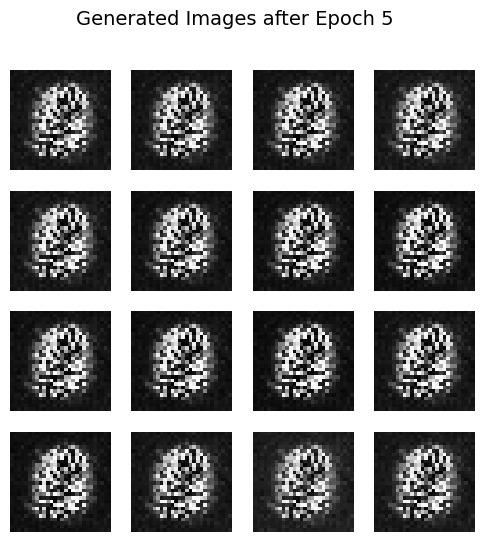

Epoch 6: D_loss=50.0000, G_loss=0.0000
Epoch 7: D_loss=50.0000, G_loss=0.0000
Epoch 8: D_loss=50.0000, G_loss=0.0000
Epoch 9: D_loss=50.0000, G_loss=0.0000
Epoch 10: D_loss=50.0000, G_loss=0.0000


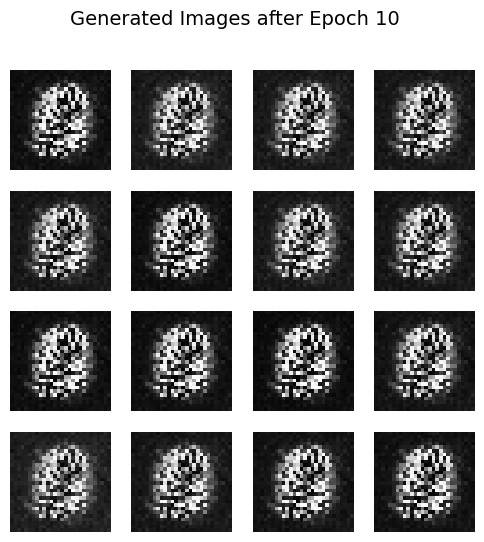

Epoch 11: D_loss=50.0000, G_loss=0.0000
Epoch 12: D_loss=50.0000, G_loss=0.0000
Epoch 13: D_loss=50.0000, G_loss=0.0000
Epoch 14: D_loss=50.0000, G_loss=0.0000
Epoch 15: D_loss=50.0000, G_loss=0.0000


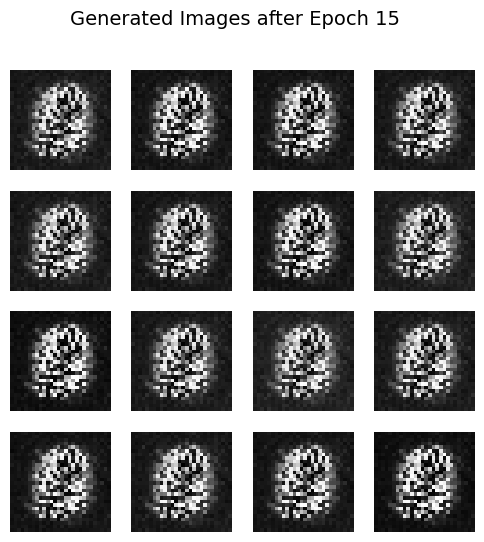

Epoch 16: D_loss=50.0000, G_loss=0.0000
Epoch 17: D_loss=50.0000, G_loss=0.0000
Epoch 18: D_loss=50.0000, G_loss=0.0000
Epoch 19: D_loss=50.0000, G_loss=0.0000
Epoch 20: D_loss=50.0000, G_loss=0.0000


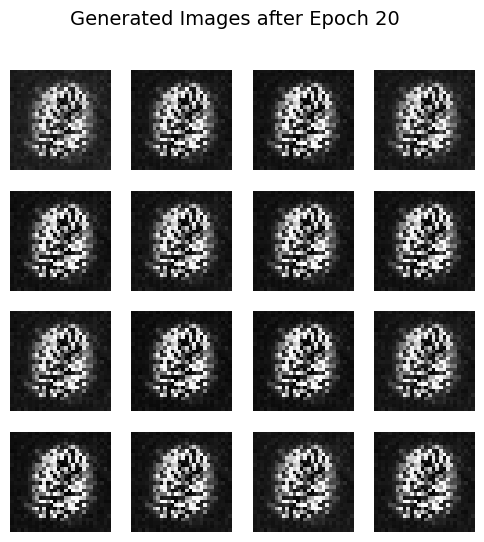

Epoch 21: D_loss=50.0000, G_loss=0.0000
Epoch 22: D_loss=50.0000, G_loss=0.0000
Epoch 23: D_loss=50.0000, G_loss=0.0000
Epoch 24: D_loss=50.0000, G_loss=0.0000
Epoch 25: D_loss=50.0000, G_loss=0.0000


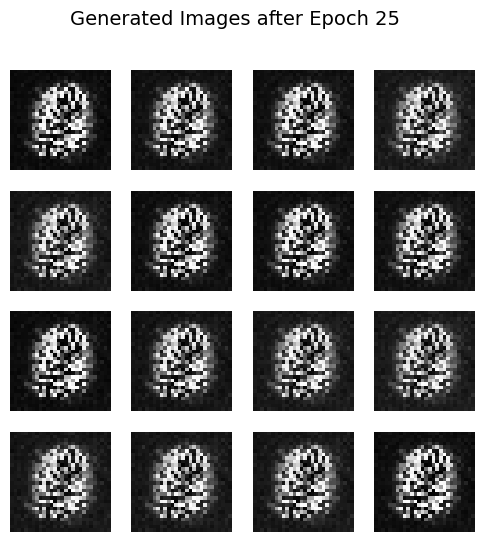

Epoch 26: D_loss=50.0000, G_loss=0.0000
Epoch 27: D_loss=50.0000, G_loss=0.0000
Epoch 28: D_loss=50.0000, G_loss=0.0000
Epoch 29: D_loss=50.0000, G_loss=0.0000
Epoch 30: D_loss=50.0000, G_loss=0.0000


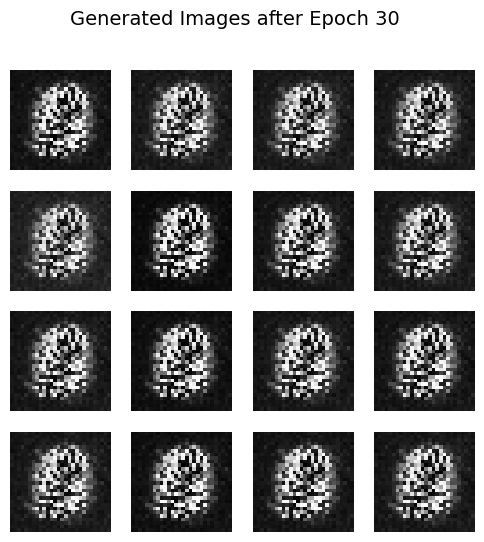

Epoch 31: D_loss=50.0000, G_loss=0.0000
Epoch 32: D_loss=50.0000, G_loss=0.0000
Epoch 33: D_loss=50.0000, G_loss=0.0000
Epoch 34: D_loss=50.0000, G_loss=0.0000
Epoch 35: D_loss=50.0000, G_loss=0.0000


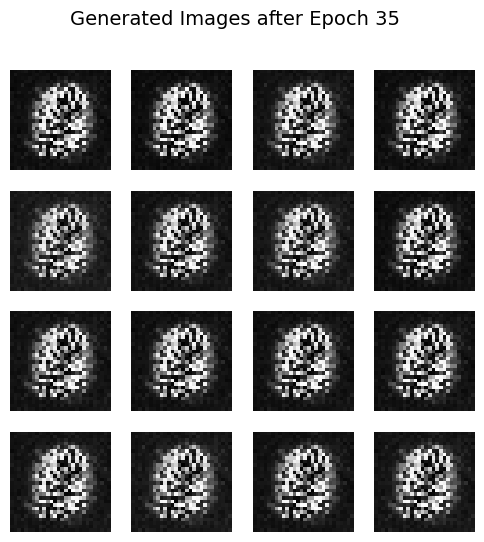

Epoch 36: D_loss=50.0000, G_loss=0.0000
Epoch 37: D_loss=50.0000, G_loss=0.0000
Epoch 38: D_loss=50.0000, G_loss=0.0000
Epoch 39: D_loss=50.0000, G_loss=0.0000
Epoch 40: D_loss=50.0000, G_loss=0.0000


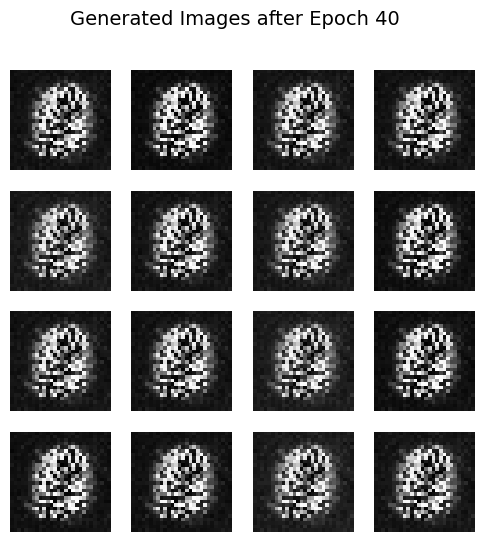

Epoch 41: D_loss=50.0000, G_loss=0.0000
Epoch 42: D_loss=50.0000, G_loss=0.0000
Epoch 43: D_loss=50.0000, G_loss=0.0000
Epoch 44: D_loss=50.0000, G_loss=0.0000
Epoch 45: D_loss=50.0000, G_loss=0.0000


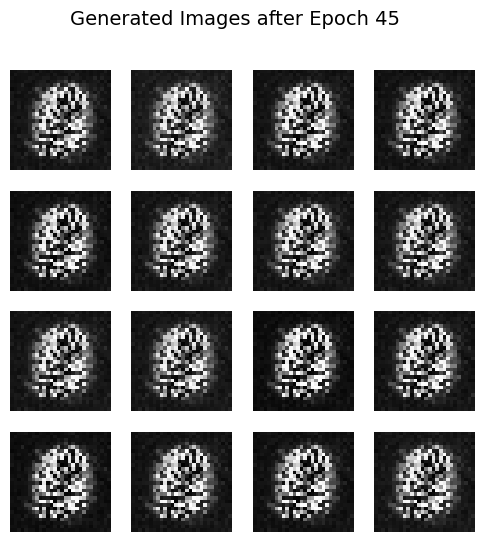

Epoch 46: D_loss=50.0000, G_loss=0.0000
Epoch 47: D_loss=50.0000, G_loss=0.0000
Epoch 48: D_loss=50.0000, G_loss=0.0000
Epoch 49: D_loss=50.0000, G_loss=0.0000
Epoch 50: D_loss=50.0000, G_loss=0.0000


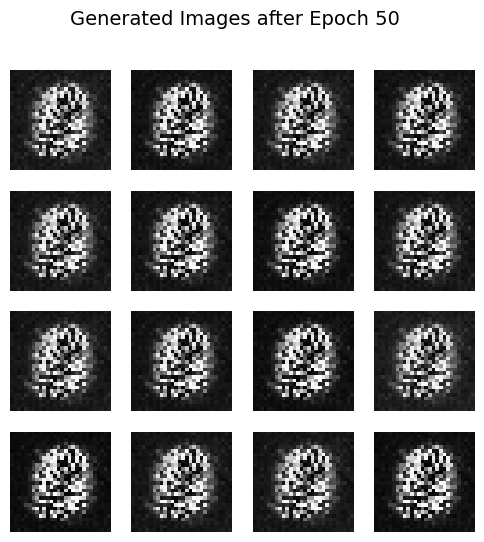

In [19]:
training()

Epoch 1: D_loss=0.1791, G_loss=2.1185
Epoch 2: D_loss=0.2726, G_loss=2.3690
Epoch 3: D_loss=0.1286, G_loss=2.4661
Epoch 4: D_loss=0.1053, G_loss=2.6634
Epoch 5: D_loss=0.1155, G_loss=2.7902


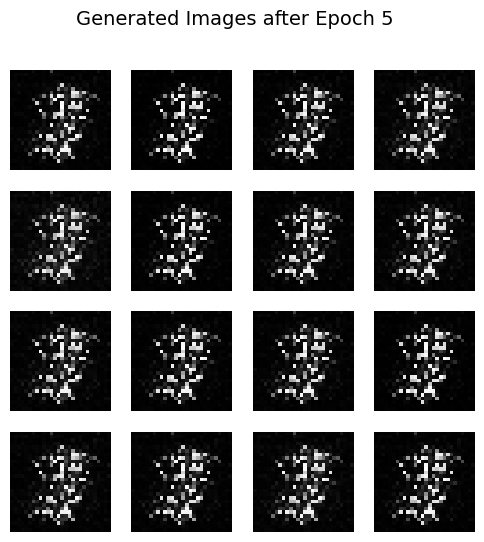

Epoch 6: D_loss=0.0862, G_loss=2.7918
Epoch 7: D_loss=0.1171, G_loss=4.0508
Epoch 8: D_loss=0.0702, G_loss=3.3225
Epoch 9: D_loss=0.1106, G_loss=3.2493
Epoch 10: D_loss=0.0775, G_loss=3.8748


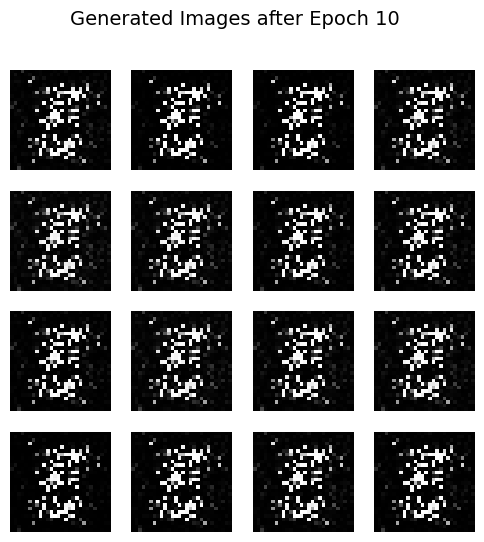

Epoch 11: D_loss=0.5457, G_loss=0.8675
Epoch 12: D_loss=0.0404, G_loss=4.1176
Epoch 13: D_loss=0.1364, G_loss=3.6339
Epoch 14: D_loss=0.0019, G_loss=6.3197
Epoch 15: D_loss=0.0048, G_loss=5.9966


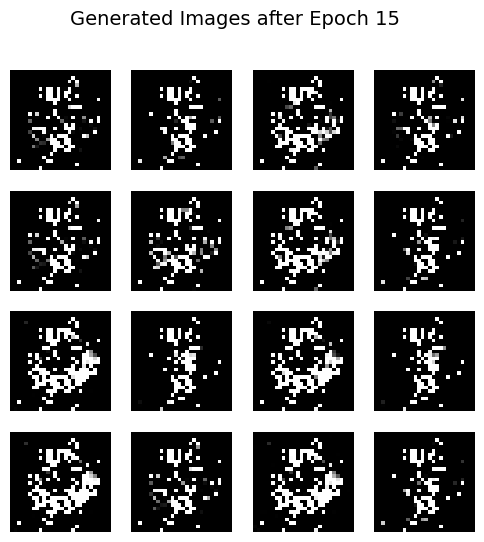

Epoch 16: D_loss=0.0005, G_loss=7.4093
Epoch 17: D_loss=0.0014, G_loss=8.4006
Epoch 18: D_loss=0.0029, G_loss=7.6477
Epoch 19: D_loss=0.0001, G_loss=9.3446
Epoch 20: D_loss=0.0002, G_loss=8.6261


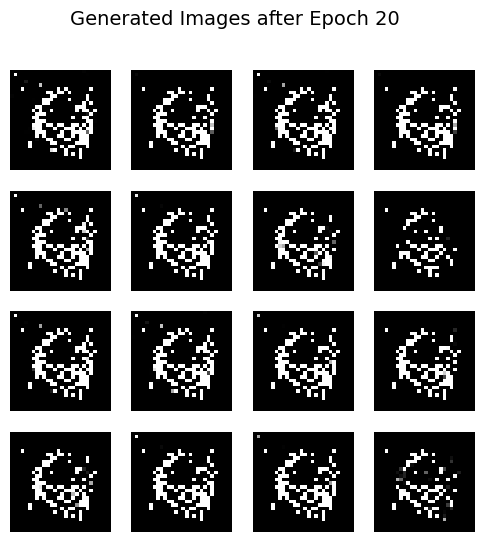

Epoch 21: D_loss=0.0002, G_loss=8.2789
Epoch 22: D_loss=0.0017, G_loss=6.9372
Epoch 23: D_loss=0.0003, G_loss=7.5855
Epoch 24: D_loss=0.0002, G_loss=8.6222
Epoch 25: D_loss=0.0001, G_loss=9.0026


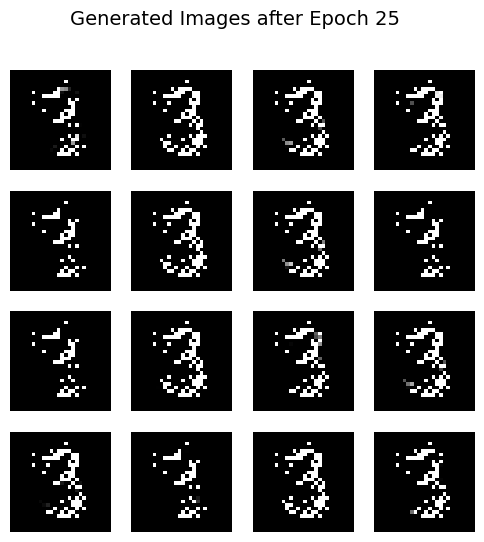

Epoch 26: D_loss=0.0001, G_loss=8.9151
Epoch 27: D_loss=0.0001, G_loss=9.7695
Epoch 28: D_loss=0.0000, G_loss=10.7587
Epoch 29: D_loss=0.0000, G_loss=10.6948
Epoch 30: D_loss=0.0000, G_loss=10.7973


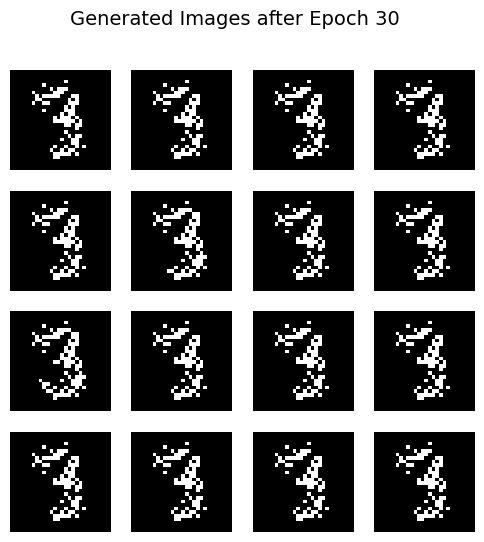

Epoch 31: D_loss=0.0000, G_loss=10.3335
Epoch 32: D_loss=0.0000, G_loss=10.1121
Epoch 33: D_loss=0.0000, G_loss=10.8654
Epoch 34: D_loss=0.0000, G_loss=10.7482
Epoch 35: D_loss=0.0000, G_loss=11.1094


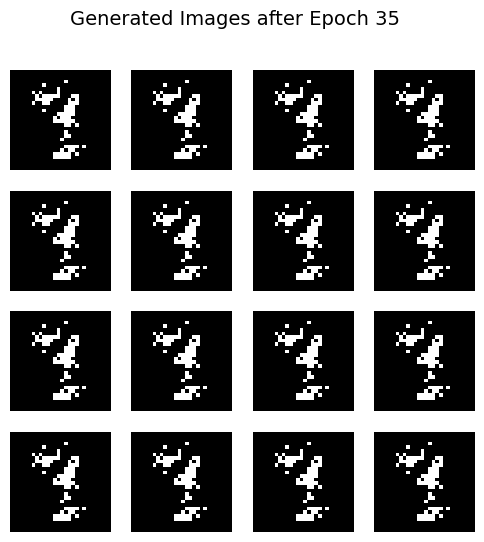

Epoch 36: D_loss=0.0000, G_loss=11.4895
Epoch 37: D_loss=0.0000, G_loss=11.4468
Epoch 38: D_loss=0.0000, G_loss=11.7862
Epoch 39: D_loss=0.0000, G_loss=11.9605
Epoch 40: D_loss=0.0000, G_loss=12.1719


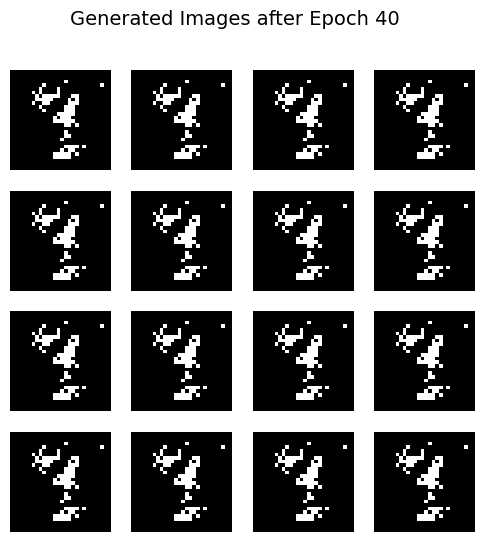

Epoch 41: D_loss=0.0000, G_loss=12.2516
Epoch 42: D_loss=0.0000, G_loss=12.3858
Epoch 43: D_loss=0.0000, G_loss=12.5052
Epoch 44: D_loss=0.0000, G_loss=12.4461
Epoch 45: D_loss=0.0000, G_loss=12.5325


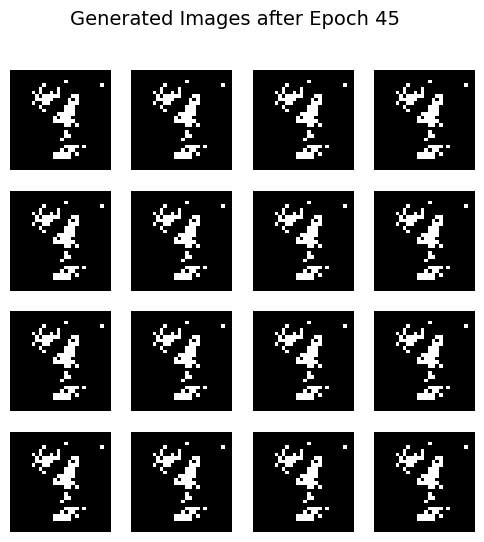

Epoch 46: D_loss=0.0000, G_loss=12.6567
Epoch 47: D_loss=0.0000, G_loss=12.7492
Epoch 48: D_loss=0.0000, G_loss=12.8208
Epoch 49: D_loss=0.0000, G_loss=12.8061
Epoch 50: D_loss=0.0000, G_loss=10.1675


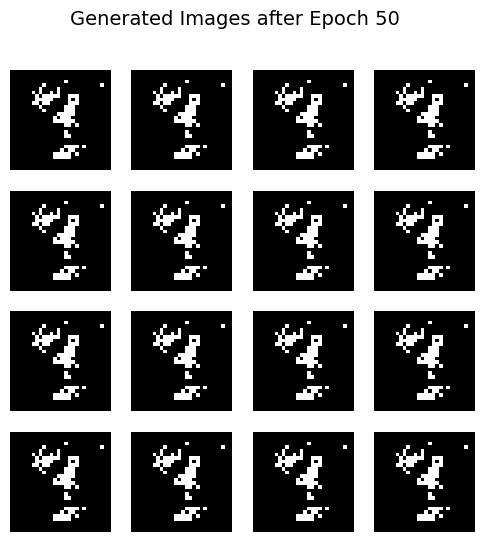

In [20]:
device = torch.device("cpu")
G = Generator(noise_dim=100).to(device)
D = Discriminator().to(device)

criterion = nn.BCELoss()
optimD = optim.SGD(D.parameters(), lr = 0.01, momentum = 0.5)
optimG = optim.SGD(G.parameters(), lr = 0.01, momentum = 0.5)

training()

Epoch 1: D_loss=0.6047, G_loss=0.9595
Epoch 2: D_loss=0.4313, G_loss=1.7858
Epoch 3: D_loss=0.4979, G_loss=1.3372
Epoch 4: D_loss=0.3707, G_loss=1.5955
Epoch 5: D_loss=0.4081, G_loss=1.4382


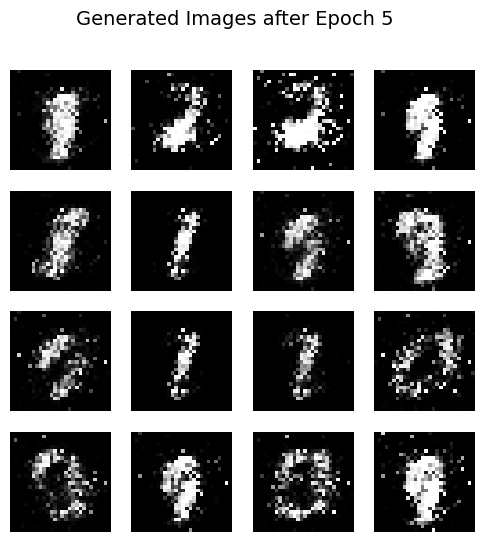

Epoch 6: D_loss=0.5276, G_loss=1.0267
Epoch 7: D_loss=0.5387, G_loss=1.5680
Epoch 8: D_loss=0.6029, G_loss=0.8807
Epoch 9: D_loss=0.5127, G_loss=1.0854
Epoch 10: D_loss=0.5686, G_loss=0.9364


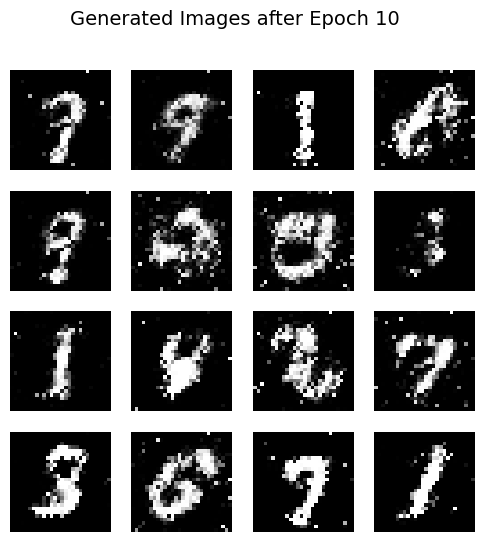

Epoch 11: D_loss=0.6545, G_loss=0.7485
Epoch 12: D_loss=0.6156, G_loss=0.7449
Epoch 13: D_loss=0.6258, G_loss=0.9420
Epoch 14: D_loss=0.6540, G_loss=1.1659
Epoch 15: D_loss=0.6259, G_loss=1.0173


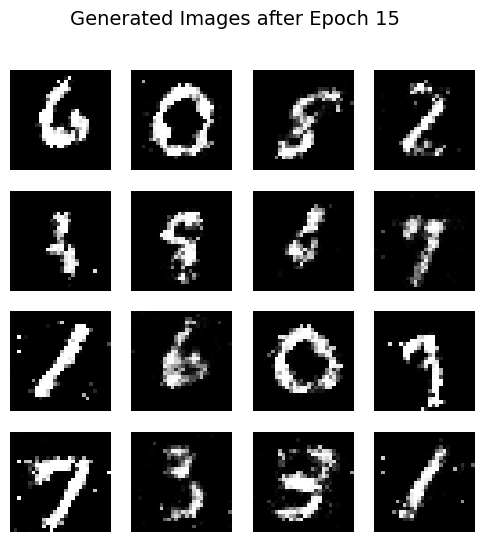

Epoch 16: D_loss=0.6045, G_loss=0.8500
Epoch 17: D_loss=0.6364, G_loss=0.8110
Epoch 18: D_loss=0.6576, G_loss=0.8018
Epoch 19: D_loss=0.6507, G_loss=0.8674
Epoch 20: D_loss=0.6219, G_loss=0.9378


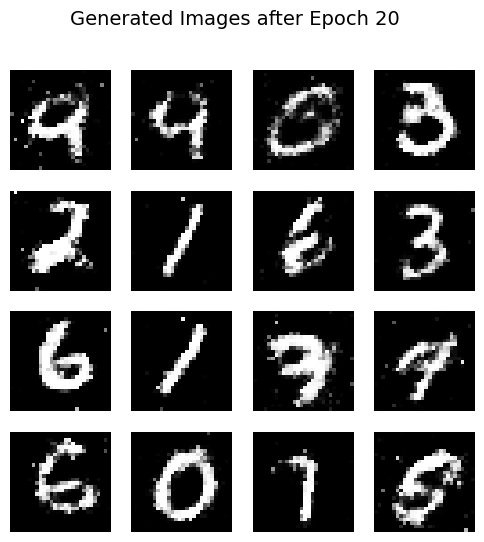

Epoch 21: D_loss=0.6681, G_loss=0.7947
Epoch 22: D_loss=0.6657, G_loss=0.6325
Epoch 23: D_loss=0.6548, G_loss=0.7960
Epoch 24: D_loss=0.6431, G_loss=1.0102
Epoch 25: D_loss=0.6812, G_loss=0.6891


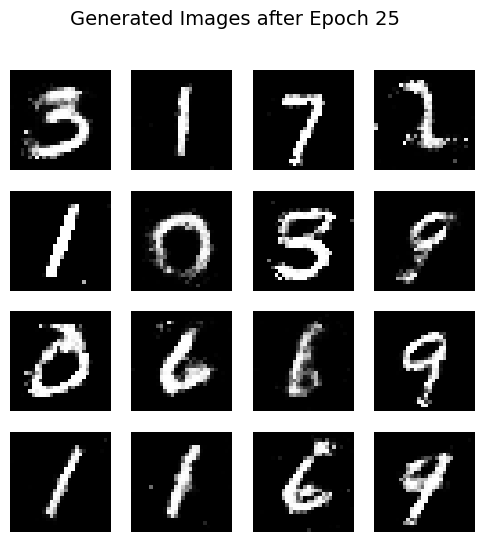

Epoch 26: D_loss=0.6692, G_loss=0.8020
Epoch 27: D_loss=0.6636, G_loss=0.6277
Epoch 28: D_loss=0.6687, G_loss=0.7694
Epoch 29: D_loss=0.6423, G_loss=0.7371
Epoch 30: D_loss=0.6749, G_loss=0.7177


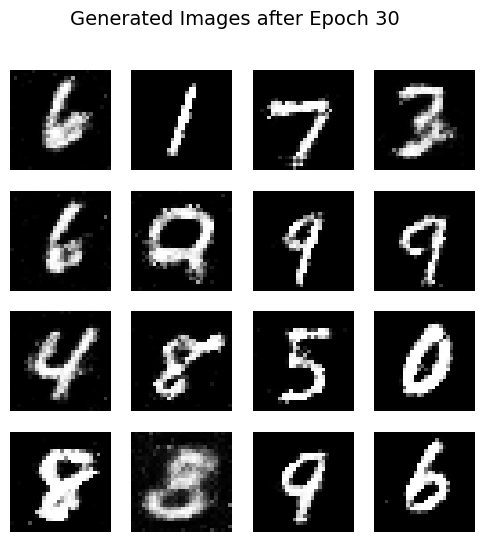

Epoch 31: D_loss=0.6553, G_loss=0.7923
Epoch 32: D_loss=0.6641, G_loss=0.7567
Epoch 33: D_loss=0.6578, G_loss=0.9549
Epoch 34: D_loss=0.6618, G_loss=0.8246
Epoch 35: D_loss=0.6733, G_loss=0.9647


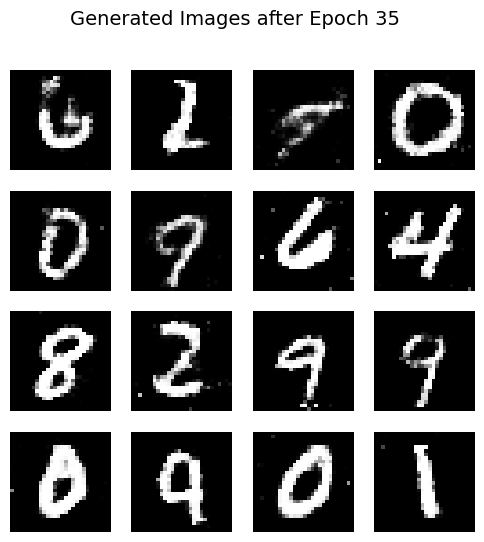

Epoch 36: D_loss=0.6588, G_loss=0.8758
Epoch 37: D_loss=0.6562, G_loss=0.7325
Epoch 38: D_loss=0.6600, G_loss=0.9982
Epoch 39: D_loss=0.6990, G_loss=0.9030
Epoch 40: D_loss=0.6822, G_loss=0.7881


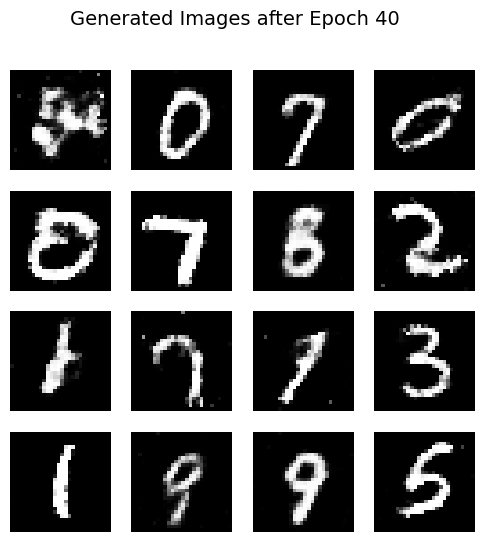

Epoch 41: D_loss=0.6885, G_loss=0.6950
Epoch 42: D_loss=0.6992, G_loss=0.7258
Epoch 43: D_loss=0.6535, G_loss=0.8446
Epoch 44: D_loss=0.6792, G_loss=0.7531
Epoch 45: D_loss=0.6779, G_loss=0.8588


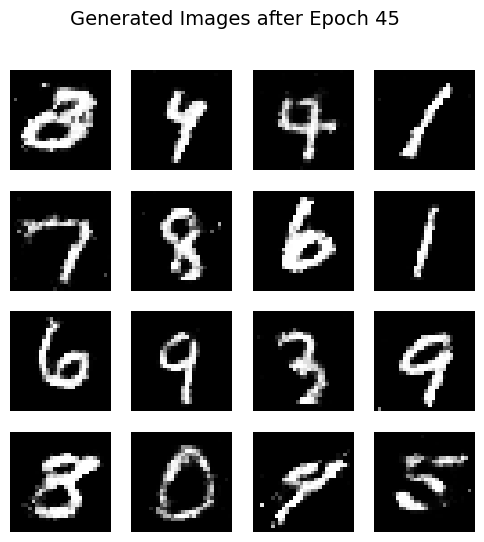

Epoch 46: D_loss=0.6418, G_loss=0.8973
Epoch 47: D_loss=0.6809, G_loss=0.7443
Epoch 48: D_loss=0.6423, G_loss=0.7778
Epoch 49: D_loss=0.6508, G_loss=0.7461
Epoch 50: D_loss=0.6555, G_loss=0.8471


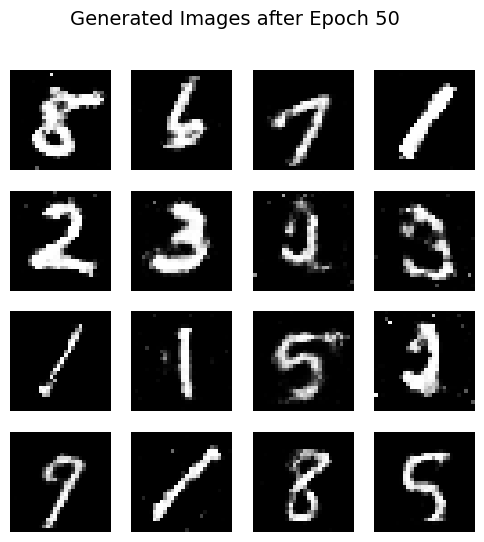

In [21]:
device = torch.device("cpu")
G = Generator(noise_dim=100).to(device)
D = Discriminator().to(device)

criterion = nn.BCELoss()
optimG = optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimD = optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))

training()